# Model selection

In [1]:
from sklearn.linear_model import BayesianRidge, LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.externals import joblib
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.svm import SVR
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Importing the dataset

In [2]:
# Import dataset
data = pd.read_csv('https://raw.githubusercontent.com/cpenalozag/twitter_network/master/dataset/dataset.csv')
print(data.shape)

(194171, 35)


### Data preparation

In [3]:
# Remove data from users that have less than 3 tweets (for stratified split)
data = data.groupby('id').filter(lambda x : len(x)>=3)

# Remove useless columns
dataset = data.drop(['common_hts','screen_name', 'description', 'tweet_id'], axis=1)

# Convert boolean data to numbers
dataset[["sensitive", "verified"]] *= 1

# One hot encoding for created at tweet
one_hot1 = pd.get_dummies(dataset['created_at_tweet'])
dataset = dataset.drop('created_at_tweet',axis = 1)
dataset = dataset.join(one_hot1)

# One hot encoding for user type
one_hot2 = pd.get_dummies(dataset['tipo'])
dataset = dataset.drop('tipo',axis = 1)
dataset = dataset.join(one_hot2)

# One hot encoding for core
one_hot3 = pd.get_dummies(dataset['partition'])
dataset = dataset.drop('partition',axis = 1)
dataset = dataset.join(one_hot3)

# Set type for categorical variables
bool_vars = ['sensitive', 'verified']
time_vars = ['afternoon', 'early morning', 'late night', 'morning', 'night', 'noon']
type_vars = ['company', 'competition', 'education', 'entertainment', 'event', 'fans', 'gossip', 'government entity', 'informative', 'journalism', 'news', 'ngo', 'personal', 'politics', 'radio', 'religion', 'sports']
cat_vars = bool_vars
cat_vars.extend(time_vars)
cat_vars.extend(type_vars)

dataset[cat_vars] = dataset[cat_vars].astype('category')

# Transform attributes to [0,1]

attributes = ['retweet_count', 'favorite_count','core', 'no_hashtags', 'no_mentions', 'average_engagement', 'listed', 'no_urls', 'effective_length', 'no_media', 'polarity', 'in_degree', 'clustering', 'closeness', 'betweenness', 'vote_rank', 'authority', 'hubs', 'pagerank']
scaler = preprocessing.MinMaxScaler()
dataset[attributes] = scaler.fit_transform(dataset[attributes])

# Transformation for special variables: followers and friends (keep meaning)
dataset[['followers', 'friends']] = dataset[['followers', 'friends']].astype(np.int32)
dataset['followers'] = data['followers'] / 19000000
dataset['friends'] = data['friends'] / 180000

# Remove retweet_count and favorite_count to remove linear dependency with y (engagement)
dataset = dataset.drop(['favorite_count','retweet_count'], axis=1)

dataset.head()

,id,sensitive,no_hashtags,no_mentions,no_urls,no_media,engagement,effective_length,polarity,subjectivity,average_engagement,core,in_degree,clustering,closeness,betweenness,vote_rank,authority,hubs,pagerank,ambassador,community_hub,followers,friends,verified,listed,afternoon,early morning,late night,morning,night,noon,company,competition,education,entertainment,event,fans,gossip,government entity,informative,journalism,news,ngo,personal,politics,radio,religion,sports,0,1,2,3,4,5,6,7,8
0,113127283,0,0.00,0.12,0.00,0.50,1,0.23,0.76,0.59,0.00,1.00,0.09,0.03,0.70,0.06,0.00,0.00,0.00,0.04,0.06,0.12,0.00,0.01,1,0.02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,113127283,0,0.00,0.10,0.00,0.50,2,0.59,0.52,0.28,0.00,1.00,0.09,0.03,0.70,0.06,0.00,0.00,0.00,0.04,0.06,0.12,0.00,0.01,1,0.02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,113127283,0,0.00,0.12,0.00,0.50,1,0.43,0.50,0.00,0.00,1.00,0.09,0.03,0.70,0.06,0.00,0.00,0.00,0.04,0.06,0.12,0.00,0.01,1,0.02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,113127283,0,0.00,0.12,0.00,0.50,0,0.31,0.50,0.00,0.00,1.00,0.09,0.03,0.70,0.06,0.00,0.00,0.00,0.04,0.06,0.12,0.00,0.01,1,0.02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,113127283,0,0.00,0.08,0.00,0.50,0,0.61,0.55,0.45,0.00,1.00,0.09,0.03,0.70,0.06,0.00,0.00,0.00,0.04,0.06,0.12,0.00,0.01,1,0.02,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [4]:
# Save scaler for deployment
joblib.dump(scaler, "scaler.pkl") 

['scaler.pkl']

### Data understanding

In [5]:
# Descriptive statistics
dataset.describe(include='all')

,id,sensitive,no_hashtags,no_mentions,no_urls,no_media,engagement,effective_length,polarity,subjectivity,average_engagement,core,in_degree,clustering,closeness,betweenness,vote_rank,authority,hubs,pagerank,ambassador,community_hub,followers,friends,verified,listed,afternoon,early morning,late night,morning,night,noon,company,competition,education,entertainment,event,fans,gossip,government entity,informative,journalism,news,ngo,personal,politics,radio,religion,sports,0,1,2,3,4,5,6,7,8
count,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00,194157.00
unique,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00,nan,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,189354.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,110751.00,nan,115970.00,164952.00,158986.00,189576.00,158602.00,182699.00,181075.00,193667.00,190981.00,160200.00,192203.00,193580.00,191734.00,171415.00,180315.00,183492.00,181975.00,189433.00,157150.00,180467.00,186902.00,193567.00,178356.00,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,487087356.41,nan,0.04,0.01,0.10,0.30,164.08,0.28,0.55,0.26,0.01,0.88,0.08,0.04,0.68,0.06,0.00,0.00,0.01,0.04,0.07,0.16,0.02,0.02,nan,0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.07,0.17,0.28,0.29,0.02,0.16,0.00,0.00,0.00
std,774303550.13,nan,0.05,0.03,0.09,0.24,1495.48,0.18,0.12,0.31,0.04,0.19,0.07,0.04,0.07,0.08,0.03,0.03,0.03,0.05,0.08,0.14,0.05,0.06,nan,0.08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.26,0.38,0.45,0.45,0.15,0.37,0.07,0.06,0.04
min,11545.00,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,100298214.00,nan,0.00,0.00,0.00,0.00,3.00,0.14,0.50,0.00,0.00,0.83,0.04,0.03,0.65,0.02,0.00,0.00,0.00,0.01,0.02,0.06,0.00,0.00,nan,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,196606310.00,nan,0.00,0.00,0.17,0.50,10.00,0.24,0.50,0.10,0.00,0.97,0.06,0.04,0.68,0.04,0.00,0.00,0.00,0.03,0.05,0.12,0.00,0.00,nan,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,397366316.00,nan,0.05,0.02,0.17,0.50,40.00,0.42,0.60,0.50,0.00,1.00,0.10,0.05,0.72,0.07,0.00,0.00,0.00,0.05,0.08,0.21,0.01,0.01,nan,0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00


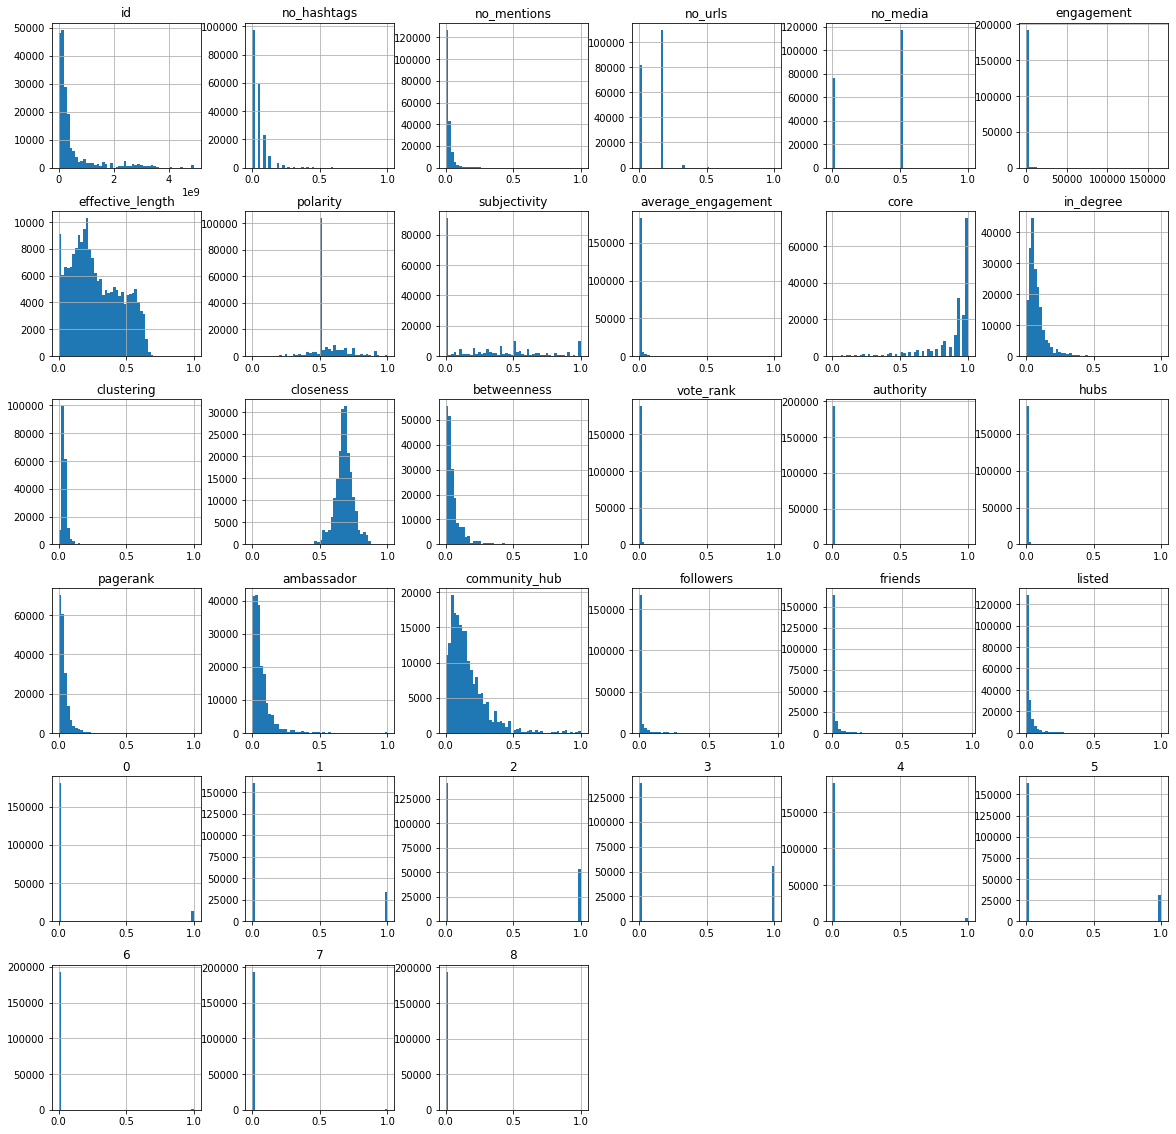

In [6]:
# Plot histograms
_ = dataset.hist(bins = 50 , figsize = (20,20))

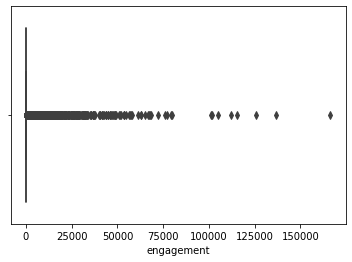

In [7]:
# Box-plot
sns.boxplot(x=dataset['engagement'])

### Create datasets excluding outliers

In [0]:
from scipy import stats
dataset['z'] = np.abs(stats.zscore(dataset['engagement']))

In [9]:
print('Length original dataset:', len(dataset))

# Indices of outliers given different criteria: >3stds, > 2.75stds, > 2.5 stds
indices2std = []
indices3std = []
indices1std = []

# Iterate through the dataset and update index lists
for index, row in dataset.iterrows():
  if row['z'] >= 0.2:
    indices2std.append(index)
  if row['z'] >= 0.3:
    indices3std.append(index)
  if row['z'] >= 1:
    indices1std.append(index)

# Create new datasets    
dataset2 = dataset.drop(indices2std)
dataset3 = dataset.drop(indices3std)
dataset1 = dataset.drop(indices1std)

# Remove data from users that have less than 2 tweets (for stratified split)
dataset2 = dataset2.groupby('id').filter(lambda x : len(x)>=2)
dataset3 = dataset3.groupby('id').filter(lambda x : len(x)>=2)
dataset1 = dataset1.groupby('id').filter(lambda x : len(x)>=2)

# Remove column with z value
dataset = dataset.drop(['z'], axis=1)

# Print length of new datasets
print('Length dataset without > 1 standard deviations:', len(dataset1))
print('Length dataset without > 0.3 standard deviations:', len(dataset3))
print('Length dataset without > 0.2 standard deviations:', len(dataset2))

Length original dataset: 194157
Length dataset without > 1 standard deviations: 191052
Length dataset without > 0.3 standard deviations: 186259
Length dataset without > 0.2 standard deviations: 184251


### Train test split

In [10]:
# Divide datasets into attributes and labels
cols = [col for col in dataset.columns if col!='engagement']
X = dataset[cols]
Y = dataset['engagement'].values
X2 = dataset2[cols]
Y2 = dataset2['engagement'].values
X3 = dataset3[cols]
Y3 = dataset3['engagement'].values
X1 = dataset1[cols]
Y1 = dataset1['engagement'].values

model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')

['model_columns.pkl']

In [0]:
# Train test split: 90%, 10%

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1, stratify = X['id'])
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.1, random_state=1, stratify = X2['id'])
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, Y3, test_size=0.1, random_state=1, stratify = X3['id'])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.1, random_state=1, stratify = X1['id'])

# Remove id from data
X_train = X_train.drop(['id'], axis=1)
X_test = X_test.drop(['id'], axis=1)
X_train2 = X_train2.drop(['id'], axis=1)
X_test2 = X_test2.drop(['id'], axis=1)
X_train3 = X_train3.drop(['id'], axis=1)
X_test3 = X_test3.drop(['id'], axis=1)
X_train1 = X_train1.drop(['id'], axis=1)
X_test1 = X_test1.drop(['id'], axis=1)

X = X.values

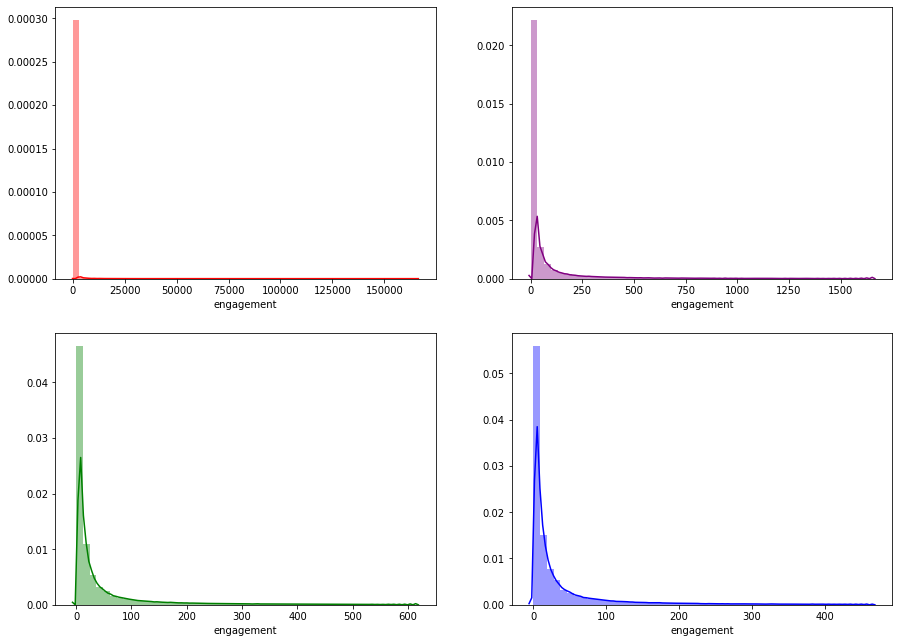

In [12]:
# Plot engagement
f, axes = plt.subplots(2, 2)
f.set_figheight(11)
f.set_figwidth(15)

sns.distplot(dataset['engagement'], color='red', ax=axes[0][0], label="Original")
sns.distplot(dataset3['engagement'], color='green', ax=axes[1][0], label="< 0.75Std")
sns.distplot(dataset1['engagement'], color='purple', ax=axes[0][1], label="<1 Std")
sns.distplot(dataset2['engagement'], color='blue', ax=axes[1][1], label="< 2Std")

## Performance regression with all variables

### Lasso regression

In [0]:
# Train lasso regression model
# Use the LassoCV object that sets its alpha parameter automatically from the
# data by internal cross-validation.
alphas = np.logspace(-4, -0.5, 30)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=0, max_iter=50000)

#### Original dataset
lasso_cv.fit(X_train,y_train)

# Predicting using test set 
y_pred_lasso_r = lasso_cv.predict(X_test)

# Lasso Regression Accuracy and MAE with test set
accuracy_lasso = r2_score(y_test, y_pred_lasso_r)
print('Lasso Regression Accuracy original dataset: ', accuracy_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso_r)
print('Lasso MAE original dataset: ', mae_lasso)

#### > 2.25Std dataset
lasso_cv.fit(X_train3,y_train3)

# Predicting using test set 
y_pred_lasso_r = lasso_cv.predict(X_test3)

# Lasso Regression Accuracy and MAE with test set
accuracy_lasso = r2_score(y_test3, y_pred_lasso_r)
print('Lasso Regression Accuracy > 0.3 sds dataset: ', accuracy_lasso)
mae_lasso = mean_absolute_error(y_test3, y_pred_lasso_r)
print('Lasso MAE > 0.3 sds dataset: ', mae_lasso)

#### > 2Std dataset
lasso_cv.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_lasso_r = lasso_cv.predict(X_test2)

# Lasso Regression Accuracy and MAE with test set
accuracy_lasso = r2_score(y_test2, y_pred_lasso_r)
print('Lasso Regression Accuracy > 2sds dataset: ', accuracy_lasso)
mae_lasso = mean_absolute_error(y_test2, y_pred_lasso_r)
print('Lasso MAE > 2sds dataset: ', mae_lasso)

#### > 1Std dataset
lasso_cv.fit(X_train1,y_train1)

# Predicting using test set 
y_pred_lasso_r = lasso_cv.predict(X_test1)

# Lasso Regression Accuracy and MAE with test set
accuracy_lasso = r2_score(y_test1, y_pred_lasso_r)
print('Lasso Regression Accuracy > 1sd dataset: ', accuracy_lasso)
mae_lasso = mean_absolute_error(y_test1, y_pred_lasso_r)
print('Lasso MAE > 1sd dataset: ', mae_lasso)

Lasso Regression Accuracy original dataset:  0.30741610486198034
Lasso MAE original dataset:  164.2172493930656
Lasso Regression Accuracy > 0.3 sds dataset:  0.3126255673517182
Lasso MAE > 2.25sds dataset:  38.676283252869794
Lasso Regression Accuracy > 2sds dataset:  0.32010164315004785
Lasso MAE > 2sds dataset:  86.13506147805353
Lasso Regression Accuracy > 1sd dataset:  0.3263965617520658
Lasso MAE > 1sd dataset:  65.63052483387973


In [0]:
# Train lasso regression model
# Use the LassoCV object that sets its alpha parameter automatically from the
# data by internal cross-validation.
alphas = np.logspace(-4, -0.5, 30)
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=0, max_iter=50000)

#### > 2Std dataset
lasso_cv.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_lasso_r = lasso_cv.predict(X_test2)

# Lasso Regression Accuracy and MAE with test set
accuracy_lasso = r2_score(y_test2, y_pred_lasso_r)
print('Lasso Regression Accuracy > 2sds dataset: ', accuracy_lasso)
mae_lasso = mean_absolute_error(y_test2, y_pred_lasso_r)
print('Lasso MAE > 2sds dataset: ', mae_lasso)

Lasso Regression Accuracy > 2sds dataset:  0.3016472230526219
Lasso MAE > 2sds dataset:  32.625872623109466


### Regularized regression

In [0]:
# Train regularized regression model
# Use the RidgeCV object that sets its alpha parameter automatically from the
# data by internal cross-validation.
reg_cv = RidgeCV(alphas=alphas, cv=5)

#### Original dataset
reg_cv.fit(X_train,y_train)

# Predicting using test set 
y_pred_rr = reg_cv.predict(X_test)

# Regularized Regression Accuracy with test set
accuracy_rr = r2_score(y_test, y_pred_rr)
print('Regularized Regression Accuracy original dataset: ', accuracy_rr)
mae_rr = mean_absolute_error(y_test, y_pred_rr)
print('Regularized Regression MAE original dataset: ', mae_rr)

#### > 3Std dataset
reg_cv.fit(X_train3,y_train3)

# Predicting using test set 
y_pred_rr = reg_cv.predict(X_test3)

# Regularized Regression Accuracy with test set
accuracy_rr = r2_score(y_test3, y_pred_rr)
print('Regularized Regression Accuracy > 3sds dataset: ', accuracy_rr)
mae_rr = mean_absolute_error(y_test3, y_pred_rr)
print('Regularized Regression MAE > 3sds dataset: ', mae_rr)

#### > 2.75Std dataset
reg_cv.fit(X_train275,y_train275)

#Predicting the SalePrices using test set 
y_pred_rr = reg_cv.predict(X_test275)

# Regularized Regression Accuracy with test set
accuracy_rr = r2_score(y_test275, y_pred_rr)
print('Regularized Regression Accuracy > 2.75 sds dataset: ', accuracy_rr)
mae_rr = mean_absolute_error(y_test275, y_pred_rr)
print('Regularized Regression MAE > 2.75sds dataset: ', mae_rr)

#### > 2.5Std dataset
reg_cv.fit(X_train25,y_train25)

#Predicting using test set 
y_pred_rr = reg_cv.predict(X_test25)

# Regularized Regression Accuracy with test set
accuracy_rr = r2_score(y_test25, y_pred_rr)
print('Regularized Regression Accuracy > 2.5 sds dataset: ', accuracy_rr)
mae_rr = mean_absolute_error(y_test25, y_pred_rr)
print('Regularized Regression MAE > 2.5sds dataset: ', mae_rr)

Regularized Regression Accuracy original dataset:  0.32900300102833957
Regularized Regression MAE original dataset:  162.550166372654
Regularized Regression Accuracy > 3sds dataset:  0.3060745686116835
Regularized Regression MAE > 3sds dataset:  101.14519680430716
Regularized Regression Accuracy > 2.75 sds dataset:  0.33334904024435275
Regularized Regression MAE > 2.75sds dataset:  97.57289222283107
Regularized Regression Accuracy > 2.5 sds dataset:  0.3299104241021473
Regularized Regression MAE > 2.5sds dataset:  92.84624032770041


In [0]:
# Train regularized regression model
# Use the RidgeCV object that sets its alpha parameter automatically from the
# data by internal cross-validation.
reg_cv = RidgeCV(alphas=alphas, cv=5)

#### > 3Std dataset
reg_cv.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_rr = reg_cv.predict(X_test2)

# Regularized Regression Accuracy with test set
accuracy_rr = r2_score(y_test2, y_pred_rr)
print('Regularized Regression Accuracy > 2sds dataset: ', accuracy_rr)
mae_rr = mean_absolute_error(y_test2, y_pred_rr)
print('Regularized Regression MAE > 2sds dataset: ', mae_rr)

Regularized Regression Accuracy > 2sds dataset:  0.3016223384157172
Regularized Regression MAE > 2sds dataset:  32.640676086540175


### SVR

In [0]:
svr = SVR()

# Train the model
svr.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_svr = svr.predict(X_test2)

# SVR Regression Accuracy with test set
accuracy_svr = r2_score(y_test2, y_pred_svr)
print('SVR Accuracy original dataset: ', accuracy_svr)
mae_svr = mean_absolute_error(y_test2, y_pred_svr)
print('SVR MAE original dataset: ', mae_svr)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR Accuracy original dataset:  -0.024604919370477152
SVR MAE original dataset:  30.027946495002304


### Random forest

In [0]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=20, min_samples_split=2, min_samples_leaf=1)

# Train the model
rf.fit(X_train,y_train)

# Predicting using test set 
y_pred_rf = rf.predict(X_test)

# Regularized Regression Accuracy with test set
accuracy_rf = r2_score(y_test, y_pred_rf)
print('Random forest Accuracy original dataset: ', accuracy_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print('Random forest Regression MAE original dataset: ', mae_rf)

# Train the model with <2 std
rf.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_rf = rf.predict(X_test2)

# Regularized Regression Accuracy with test set
accuracy_rf = r2_score(y_test2, y_pred_rf)
print('Random forest Accuracy dataset (2 std): ', accuracy_rf)
mae_rf = mean_absolute_error(y_test2, y_pred_rf)
print('Random forest Regression MAE dataset (2 std): ', mae_rf)

# Train the model with <1 std
rf.fit(X_train1,y_train1)

# Predicting using test set 
y_pred_rf = rf.predict(X_test1)

# Regularized Regression Accuracy with test set
accuracy_rf = r2_score(y_test1, y_pred_rf)
print('Random forest Accuracy dataset (1 std): ', accuracy_rf)
mae_rf = mean_absolute_error(y_test1, y_pred_rf)
print('Random forest Regression MAE dataset (1 std): ', mae_rf)

# Train the model with <0.3 std
rf.fit(X_train3,y_train3)

# Predicting using test set 
y_pred_rf = rf.predict(X_test3)

# Regularized Regression Accuracy with test set
accuracy_rf = r2_score(y_test3, y_pred_rf)
print('Random forest Accuracy dataset (0.3 std): ', accuracy_rf)
mae_rf = mean_absolute_error(y_test3, y_pred_rf)
print('Random forest Regression MAE dataset  (0.3 std): ', mae_rf)

Random forest Accuracy original dataset:  0.28518274389027465
Random forest Regression MAE original dataset:  142.3104527927109
Random forest Accuracy dataset (2 std):  0.5555765354818839
Random forest Regression MAE dataset (2 std):  21.878700340347077
Random forest Accuracy dataset (1 std):  0.5452783716162499
Random forest Regression MAE dataset (1 std):  43.95405812412026
Random forest Accuracy dataset (0.3 std):  0.5571734723125121
Random forest Regression MAE dataset  (0.3 std):  25.79183188577503


In [0]:
rf = RandomForestRegressor()
# Train the model with <2 std
rf.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_rf = rf.predict(X_test2)

# Regularized Regression Accuracy with test set
accuracy_rf = r2_score(y_test2, y_pred_rf)
print('Random forest Accuracy dataset (2 std): ', accuracy_rf)
mae_rf = mean_absolute_error(y_test2, y_pred_rf)
print('Random forest Regression MAE dataset (2 std): ', mae_rf)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random forest Accuracy dataset (2 std):  0.4982536486437935
Random forest Regression MAE dataset (2 std):  23.308165606575496


In [0]:
# Train the model with <2 std
rf.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_rf = rf.predict(X_test2)

# Regularized Regression Accuracy with test set
accuracy_rf = r2_score(y_test2, y_pred_rf)
print('Random forest Accuracy dataset (2 std): ', accuracy_rf)
mae_rf = mean_absolute_error(y_test2, y_pred_rf)
print('Random forest Regression MAE dataset (2 std): ', mae_rf)

Random forest Accuracy dataset (2 std):  0.5545918639065743
Random forest Regression MAE dataset (2 std):  21.902237770164966


In [0]:
joblib.dump(rf, 'model.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['model.pkl']

### MLP

In [0]:
best_params = {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 
               'hidden_layer_sizes': 4, 'learning_rate': 'constant', 
               'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'lbfgs'}

mlp = MLPRegressor()

# Train the model
mlp.fit(X_train,y_train)

# Predicting using test set 
y_pred_mlp = mlp.predict(X_test)

# MLP Regression Accuracy with test set
accuracy_mlp = r2_score(y_test, y_pred_mlp)
print('MLP Accuracy original dataset: ', accuracy_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
print('MLP Regression MAE original dataset: ', mae_mlp)

# Train the model with <2.5 std
mlp.fit(X_train25,y_train25)

# Predicting using test set 
y_pred_mlp = mlp.predict(X_test25)

# MLP Regression Accuracy with test set
accuracy_mlp = r2_score(y_test25, y_pred_mlp)
print('MLP Accuracy dataset (2.5std): ', accuracy_mlp)
mae_mlp = mean_absolute_error(y_test25, y_pred_mlp)
print('MLP Regression MAE dataset  (2.5std): ', mae_mlp)

# Train the model with <2.25 std
mlp.fit(X_train3,y_train3)

# Predicting using test set 
y_pred_mlp = mlp.predict(X_test3)

# MLP Regression Accuracy with test set
accuracy_mlp = r2_score(y_test3, y_pred_mlp)
print('MLP Accuracy dataset (2.25std): ', accuracy_mlp)
mae_mlp = mean_absolute_error(y_test3, y_pred_mlp)
print('MLP Regression MAE dataset  (2.25std): ', mae_mlp)

# Train the model with <2 std
mlp.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_mlp = mlp.predict(X_test2)

# MLP Regression Accuracy with test set
accuracy_mlp = r2_score(y_test2, y_pred_mlp)
print('MLP Accuracy dataset (2std): ', accuracy_mlp)
mae_mlp = mean_absolute_error(y_test2, y_pred_mlp)
print('MLP Regression MAE dataset  (2std): ', mae_mlp)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Accuracy original dataset:  0.3291704437349938
MLP Regression MAE original dataset:  177.01168633470314


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP Accuracy dataset (2.5std):  0.46316562995160837
MLP Regression MAE dataset  (2.5std):  76.62356316589998


NameError: ignored

In [0]:
mlp = MLPRegressor()

# Train the model with <2 std
mlp.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_mlp = mlp.predict(X_test2)

# MLP Regression Accuracy with test set
accuracy_mlp = r2_score(y_test2, y_pred_mlp)
print('MLP Accuracy dataset (2std): ', accuracy_mlp)
mae_mlp = mean_absolute_error(y_test2, y_pred_mlp)
print('MLP Regression MAE dataset  (2std): ', mae_mlp)

MLP Accuracy dataset (2std):  0.4966776169990159
MLP Regression MAE dataset  (2std):  26.287101524697196


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### GBR

In [0]:
gbr = GradientBoostingRegressor(n_estimators=1000)

# Train the model
gbr.fit(X_train,y_train)

# Predicting using test set 
y_pred_gbr = gbr.predict(X_test)

# Regularized Regression Accuracy with test set
accuracy_gbr = r2_score(y_test, y_pred_gbr)
print('GBR Accuracy original dataset: ', accuracy_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
print('GB Regression MAE original dataset: ', mae_gbr)

# Train the model with <1 std
gbr.fit(X_train1,y_train1)

# Predicting using test set 
y_pred_gbr = gbr.predict(X_test1)

# Regularized Regression Accuracy with test set
accuracy_gbr = r2_score(y_test1, y_pred_gbr)
print('GBR Accuracy dataset (1std): ', accuracy_gbr)
mae_gbr = mean_absolute_error(y_test1, y_pred_gbr)
print('GB Regression MAE dataset  (1std): ', mae_gbr)

# Train the model with <2.25 std
gbr.fit(X_train3,y_train3)

# Predicting using test set 
y_pred_gbr = gbr.predict(X_test3)

# Regularized Regression Accuracy with test set
accuracy_gbr = r2_score(y_test3, y_pred_gbr)
print('GBR Accuracy dataset (0.3std): ', accuracy_gbr)
mae_gbr = mean_absolute_error(y_test3, y_pred_gbr)
print('GB Regression MAE dataset  (0.3std): ', mae_gbr)

# Train the model with <2 std
gbr.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_gbr = gbr.predict(X_test2)

# Regularized Regression Accuracy with test set
accuracy_gbr = r2_score(y_test2, y_pred_gbr)
print('GBR Accuracy dataset (0.2std): ', accuracy_gbr)
mae_gbr = mean_absolute_error(y_test2, y_pred_gbr)
print('GB Regression MAE dataset  (0.2std): ', mae_gbr)

GBR Accuracy original dataset:  0.356221422639602
GB Regression MAE original dataset:  146.29975859235125


KeyboardInterrupt: ignored

In [0]:
gbr = GradientBoostingRegressor()

# Train the model with <2 std
gbr.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_gbr = gbr.predict(X_test2)

# Regularized Regression Accuracy with test set
accuracy_gbr = r2_score(y_test2, y_pred_gbr)
print('GBR Accuracy dataset (0.2std): ', accuracy_gbr)
mae_gbr = mean_absolute_error(y_test2, y_pred_gbr)
print('GB Regression MAE dataset  (0.2std): ', mae_gbr)

GBR Accuracy dataset (0.2std):  0.5066779954507963
GB Regression MAE dataset  (0.2std):  24.220723322792097


In [0]:
joblib.dump(gbr, 'model2.pkl')

['model2.pkl']

### Knn

In [0]:
knn = KNeighborsRegressor(n_neighbors=11)

# Train the model
knn.fit(X_train,y_train)

# Predicting using test set 
y_pred_knn = knn.predict(X_test)

# Regularized Regression Accuracy with test set
accuracy_knn = r2_score(y_test, y_pred_knn)
print('Knn Accuracy original dataset: ', accuracy_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
print('Knn Regression MAE original dataset: ', mae_knn)


# Train the model with <0.2 std
knn.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_knn = knn.predict(X_test2)

# Regularized Regression Accuracy with test set
accuracy_knn = r2_score(y_test2, y_pred_knn)
print('Knn Accuracy original dataset (0.2std): ', accuracy_knn)
mae_knn = mean_absolute_error(y_test2, y_pred_knn)
print('Knn Regression MAE original dataset  (0.2std): ', mae_knn)

Knn Accuracy original dataset:  0.29872019263962246
Knn Regression MAE original dataset:  160.42740289171067
Knn Accuracy original dataset (0.2std):  0.33441808105848003
Knn Regression MAE original dataset  (0.2std):  28.46359886721333


In [0]:
knn = KNeighborsRegressor()

# Train the model with <0.2 std
knn.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_knn = knn.predict(X_test2)

# Regularized Regression Accuracy with test set
accuracy_knn = r2_score(y_test2, y_pred_knn)
print('Knn Accuracy original dataset (0.2std): ', accuracy_knn)
mae_knn = mean_absolute_error(y_test2, y_pred_knn)
print('Knn Regression MAE original dataset  (0.2std): ', mae_knn)

Knn Accuracy original dataset (0.2std):  0.3228110910580384
Knn Regression MAE original dataset  (0.2std):  28.02302181699772


## Feature selection
Feature selection will be made using embedded methods: insights provided by some Machine Learning models.
- LASSO regression
- Tree based model

### Lasso regression

Lasso regression, or the Least Absolute Shrinkage and Selection Operator, is also a modification of linear regression. In Lasso, the loss function is modified to minimize the complexity of the model by limiting the sum of the absolute values of the model coefficients (also called the l1-norm).
The loss function for Lasso Regression can be expressed as below:

```
Loss function = OLS + alpha * summation (absolute values of the magnitude of the coefficients)
```

In the above loss function, alpha is the penalty parameter we need to select. Using an l1 norm constraint, apart from preventing overfitting, also reduces the coefficients of less important features to zero.

In [0]:
# Use the LassoCV object that sets its alpha parameter automatically from the
# data by internal cross-validation.
alphas = np.logspace(-4, -0.5, 50)
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=0, max_iter=100000)

# Set a minimum threshold of 0.70: Features whose importance is greater or equal are kept while the others are discarded. 
sfm = SelectFromModel(lasso_cv, threshold=0.70)
sfm.fit(X_train, y_train)
n_features = sfm.transform(X_train).shape[1]

# Extracting the index of important features
feature_idx = sfm.get_support()

# Using the index to print the names of the important variables
X_train.columns[feature_idx]
important_variables = list(X_train.columns[feature_idx])
important_variables.extend(['id','engagement'])

In [0]:
# Dataset with only important variables
dataset2 = dataset[important_variables]
dataset2.head()

In [0]:
cols = [col for col in dataset2.columns if col!='engagement']

X2 = dataset2[cols]
Y2 = dataset2['engagement'].values

# Train test split: 80%, 20%
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.2, random_state=1, stratify = X2['id'])

# Remove id from data
X_train2 = X_train2.drop(['id'], axis=1)
X_test2 = X_test2.drop(['id'], axis=1)

X2 = X2.values

In [0]:
# Train lasso regression model
# Use the LassoCV object that sets its alpha parameter automatically from the
# data by internal cross-validation.
lasso_cv.fit(X_train2,y_train2)

# Predicting using test set 
y_pred_lasso_r = lasso_cv.predict(X_test2)

# Lasso Regression Accuracy and MAE with test set
accuracy_lasso = r2_score(y_test2, y_pred_lasso_r)
print('Lasso Regression Accuracy original dataset: ', accuracy_lasso)
mae_lasso = mean_absolute_error(y_test2, y_pred_lasso_r)
print('Lasso MAE original dataset: ', mae_lasso)

In [0]:
# Coefficients of Lasso regression
coef = pd.Series(lasso_cv.coef_, index = X_train.columns)
coef_df = pd.DataFrame(list(zip(X_train.columns, lasso_cv.coef_)), columns =['variable', 'coef'])
coef_df.head()

In [0]:
# Feature selection
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

In [0]:
# Coefficient visualization
ranking = np.argsort(-rf_regressor.feature_importances_)
f, ax = plt.subplots(figsize=(10, 30))
sns.barplot(x=rf_regressor.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [0]:
# Keep 10 most dominant features
X_train2 = X_train.iloc[:,ranking[:10]]
X_test2 = X_test.iloc[:,ranking[:10]]

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(X_train2,y_train)

#Predicting the SalePrices using test set 
y_pred_lr = lin_reg.predict(X_test2)

#Mutiple Linear Regression Accuracy with test set
accuracy_lf = r2_score(y_test, y_pred_lr)
print('Mutiple Linear Regression Accuracy: ', accuracy_lf)

#Predicting the SalePrice using cross validation (KFold method)
y_pred_kf_lr = cross_val_predict(lin_reg, X, Y, cv=10 )

#Mutiple Linear Regression Accuracy with cross validation (KFold method)
accuracy_lf = r2_score(Y, y_pred_kf_lr)
print('Cross-Predicted(KFold) Mutiple Linear Regression Accuracy: ', accuracy_lf)

### Extra trees

In [0]:
# fit an Extra Trees model to the data
etc = ExtraTreesRegressor()
etc.fit(X_train, y_train)
 
# Finally selecting the most important features
sfm = SelectFromModel(etc, threshold=0.15)
sfm.fit(X_train, y_train)
 
# Printing the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(X_train.columns[feature_list_index])
    
# getting the score by relative importance of each attribute
print(etc.feature_importances_)